# **Redes Recurrentes**


In [40]:
#import libreries

import tensorflow as tf
import numpy as np
import pandas as pd
import datasets 
import matplotlib.pyplot as plt

import keras 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# -- Keras Import
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.preprocessing import image

from keras.datasets import imdb
from keras.datasets import mnist

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

from keras.utils import np_utils
from keras.preprocessing import sequence
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Embedding
from keras.layers import Bidirectional, LSTM, GRU, SimpleRNN

from keras.layers import Activation, TimeDistributed, RepeatVector
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.layers import TextVectorization
from gensim.parsing.porter import PorterStemmer 
from gensim.parsing.preprocessing import remove_stopwords
import re
from keras.preprocessing.text import Tokenizer
import pickle

In [23]:
max_features = 20000
maxlen = 100  # cut texts after this number of words (among top max_features most common words)
batch_size = 32

print("Loading data...")

#download data
dataset = datasets.load_dataset('ucberkeley-dlab/measuring-hate-speech', 'binary')   

# Read data
df = dataset['train'].to_pandas()

df.head()


Loading data...


  0%|          | 0/1 [00:00<?, ?it/s]

,comment_id,annotator_id,platform,sentiment,respect,insult,humiliate,status,dehumanize,violence,...,annotator_religion_hindu,annotator_religion_jewish,annotator_religion_mormon,annotator_religion_muslim,annotator_religion_nothing,annotator_religion_other,annotator_sexuality_bisexual,annotator_sexuality_gay,annotator_sexuality_straight,annotator_sexuality_other
0,47777,10873,3,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
1,39773,2790,2,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
2,47101,3379,3,4.0,4.0,4.0,4.0,4.0,4.0,0.0,...,False,False,False,False,True,False,False,False,True,False
3,43625,7365,3,2.0,3.0,2.0,1.0,2.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
4,12538,488,0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,False,False,False,False,False,False,False,False,True,False


In [24]:
df.hatespeech.value_counts()

0.0    80624
2.0    46021
1.0     8911
Name: hatespeech, dtype: int64

In [25]:
def preprocessing(document: str) -> list:
    """
    convert text to lowercase
    remove no latin caracters 
    remove punctuation 
    remove extra spaces
    do stemming text
    """
    document = document.lower()
    document = remove_stopwords(document)
    document = re.sub('\n', ' ', document)
    document = re.sub('[^a-zA-Z]|[0-9]', ' ', document)
    document = re.sub('\s+', ' ', document)
    p = PorterStemmer()
    document = p.stem_sentence(document)
    return document

In [26]:
df['text']=df.text.apply(preprocessing)

In [28]:
X = df[['comment_id','annotator_id','platform','sentiment','respect','insult','humiliate','status','dehumanize','violence','genocide','attack_defend','hatespeech','hate_speech_score','text','infitms','outfitms','annotator_severity','std_err','annotator_infitms','annotator_outfitms','hypothesis','target_race_asian','target_race_black','target_race_latinx','target_race_middle_eastern','target_race_native_american','target_race_pacific_islander','target_race_white','target_race_other','target_race','target_religion_atheist','target_religion_buddhist','target_religion_christian','target_religion_hindu','target_religion_jewish','target_religion_mormon','target_religion_muslim','target_religion_other','target_religion','target_origin_immigrant','target_origin_migrant_worker','target_origin_specific_country','target_origin_undocumented','target_origin_other','target_origin','target_gender_men','target_gender_non_binary','target_gender_transgender_men','target_gender_transgender_unspecified','target_gender_transgender_women','target_gender_women','target_gender_other','target_gender','target_sexuality_bisexual','target_sexuality_gay','target_sexuality_lesbian','target_sexuality_straight','target_sexuality_other','target_sexuality','target_age_children','target_age_teenagers','target_age_young_adults','target_age_middle_aged','target_age_seniors','target_age_other','target_age','target_disability_physical','target_disability_cognitive','target_disability_neurological','target_disability_visually_impaired','target_disability_hearing_impaired','target_disability_unspecific','target_disability_other','target_disability','annotator_gender','annotator_trans','annotator_educ','annotator_income','annotator_ideology','annotator_gender_men','annotator_gender_women','annotator_gender_non_binary','annotator_gender_prefer_not_to_say','annotator_gender_self_describe','annotator_transgender','annotator_cisgender','annotator_transgender_prefer_not_to_say','annotator_education_some_high_school','annotator_education_high_school_grad','annotator_education_some_college','annotator_education_college_grad_aa','annotator_education_college_grad_ba','annotator_education_professional_degree','annotator_education_masters','annotator_education_phd','annotator_income_<10k','annotator_income_10k-50k','annotator_income_50k-100k','annotator_income_100k-200k','annotator_income_>200k','annotator_ideology_extremeley_conservative','annotator_ideology_conservative','annotator_ideology_slightly_conservative','annotator_ideology_neutral','annotator_ideology_slightly_liberal','annotator_ideology_liberal','annotator_ideology_extremeley_liberal','annotator_ideology_no_opinion','annotator_race_asian','annotator_race_black','annotator_race_latinx','annotator_race_middle_eastern','annotator_race_native_american','annotator_race_pacific_islander','annotator_race_white','annotator_race_other','annotator_age','annotator_religion_atheist','annotator_religion_buddhist','annotator_religion_christian','annotator_religion_hindu','annotator_religion_jewish','annotator_religion_mormon','annotator_religion_muslim','annotator_religion_nothing','annotator_religion_other','annotator_sexuality_bisexual','annotator_sexuality_gay','annotator_sexuality_straight','annotator_sexuality_other']]

y = df.hatespeech

In [30]:
X = df['text']
X

0         ye inde sort remind elder ladi plai movi titan...
1                        tran women read tweet right beauti
2         question broad critic america countri flee her...
3         time illeg countri origin freewai open prevent...
4         starter bend pink kick ass pussi tast she s be...
                                ...                        
135551    break new sayi abdulmalik the saudi regim lear...
135552    million yemen is particip mass ralli squar gov...
135553    abeshinzo realdonaldtrump shinzoab dictat goe ...
135554    million yemen is particip mass ralli squar gov...
135555    op hope commit suicid dai die ass cancer feel ...
Name: text, Length: 135556, dtype: object

### **Replace hatespeech == 1 with 2** 

In [8]:
# replace 1 with 2 in y
y = [1 if x==2 else x for x in y]

In [9]:
y = np.array(y)

### **Split in train and test data** 

In [10]:
X_train_validation, X_test, y_train_validation, y_test = train_test_split(X,y,
                                                    random_state=1,test_size=0.3)

X_train, X_validation, y_train, y_validation = train_test_split(X_train_validation, 
                                                    y_train_validation, 
                                                    random_state=1,test_size=0.33)

print('Number of rows in the total set: {}'.format(df.shape[0]))
print('Number of rows in the training set: {}'.format(len(X_train)))
print('Number of rows in the validation set: {}'.format(len(X_validation)))
print('Number of rows in the test set: {}'.format(len(X_test)))

Number of rows in the total set: 135556
Number of rows in the training set: 63575
Number of rows in the validation set: 31314
Number of rows in the test set: 40667


In [11]:
from keras_preprocessing import sequence

max_words = 20000
max_len = 150

word_token = Tokenizer(num_words=max_words)
word_token.fit_on_texts(X_train)
sequences = word_token.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [12]:
sequences_matrix.shape[0]

63575

In [13]:
print('Build model...')

from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding

max_features = 20000
maxlen = 150 
batch_size = 32


model = Sequential()
model.add(Embedding(max_features, batch_size, input_length=maxlen))
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Dense(1))
model.add(Activation('sigmoid'))

Build model...


In [14]:
from tensorflow.keras.optimizers import RMSprop,Adam

#model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 32)           640000    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               82432     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 730,753
Trainable params: 730,753
Non-trainable params: 0
__________________________________________________

In [15]:
history = model.fit(sequences_matrix,y_train,batch_size=32,epochs=10,validation_split=0.2)

Epoch 1/10
1590/1590 [==============================] - 98s 61ms/step - loss: 0.4611 - accuracy: 0.7844 - val_loss: 0.4414 - val_accuracy: 0.7976
Epoch 2/10
1590/1590 [==============================] - 97s 61ms/step - loss: 0.4284 - accuracy: 0.8062 - val_loss: 0.4317 - val_accuracy: 0.8018
Epoch 3/10
1590/1590 [==============================] - 93s 58ms/step - loss: 0.4206 - accuracy: 0.8114 - val_loss: 0.4315 - val_accuracy: 0.8049
Epoch 4/10
1590/1590 [==============================] - 97s 61ms/step - loss: 0.4139 - accuracy: 0.8174 - val_loss: 0.4411 - val_accuracy: 0.8053
Epoch 5/10
1590/1590 [==============================] - 95s 59ms/step - loss: 0.4076 - accuracy: 0.8224 - val_loss: 0.4287 - val_accuracy: 0.8070
Epoch 6/10
1590/1590 [==============================] - 96s 60ms/step - loss: 0.4037 - accuracy: 0.8235 - val_loss: 0.4534 - val_accuracy: 0.8057
Epoch 7/10
1590/1590 [==============================] - 94s 59ms/step - loss: 0.3947 - accuracy: 0.8294 - val_loss: 0.4357 -

In [16]:
test_sequences = word_token.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [17]:
accr = model.evaluate(test_sequences_matrix,y_test)

1271/1271 [==============================] - 26s 20ms/step - loss: 0.4448 - accuracy: 0.7939


In [18]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.445
  Accuracy: 0.794


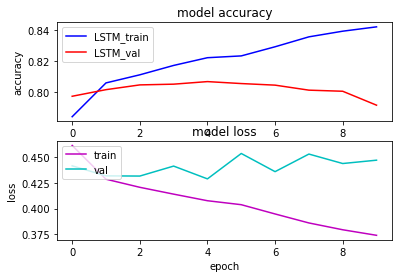

In [19]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

In [32]:
# Evaluación del modelo

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,  confusion_matrix, classification_report

predictions = model.predict(y_test)

In [37]:
print('Accuracy score: ', format(accuracy_score(y_test, predictions.round())))
print('Precision score: ', format(precision_score(y_test, predictions.round())))
print('Recall score: ', format(recall_score(y_test, predictions.round())))
print('F1 score: ', format(f1_score(y_test, predictions.round())))

Accuracy score:  0.5965524872746945
Precision score:  0.0
Recall score:  0.0
F1 score:  0.0


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
pred = model.predict(y_test)  
report = classification_report(y_test ,pred.round())  
print(report)
#En terminos de TP, FP, TN, FN
tn, fp, fn, tp = confusion_matrix(y_test, pred.round()).ravel()
(tn,fp,fn,tp)

              precision    recall  f1-score   support

         0.0       0.60      1.00      0.75     24260
         1.0       0.00      0.00      0.00     16407

    accuracy                           0.60     40667
   macro avg       0.30      0.50      0.37     40667
weighted avg       0.36      0.60      0.45     40667



c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(24260, 0, 16407, 0)

In [46]:
def get_sequence_Matrix(df):
    word_token = Tokenizer(num_words=max_words)
    word_token.fit_on_texts(df)
    sequences = word_token.texts_to_sequences(df)
    sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)
    return sequences_matrix

In [47]:


get_sequence_Matrix(X_test)

array([[   0,    0,    0, ...,    2,   16,  960],
       [   0,    0,    0, ...,  251,   50,    5],
       [   0,    0,    0, ...,  303,   17,   34],
       ...,
       [   0,    0,    0, ...,  831, 1566,   49],
       [   0,    0,    0, ..., 9746,  178,   11],
       [   0,    0,    0, ...,  726,   13,  660]])

121083    nigger liber friend steal ti down like presid ...
131435    i cathol jesuit grate muslim holi season chall...
44688                 gai school i hope shove hoe bitch ass
109110    rt jihadistjo muslim militari honour whatsoev ...
113040    god look barbar ppl pig watch r veri sick cult...
                                ...                        
95440     won american know give peopl power dai unaccep...
114866    cam cole don t know know somebodi colder monke...
91078     near ultim exampl tone deaf white privileg fil...
86210     gaz ed that screw wish death person especi chi...
120499    woman fuck failur paedophil protect globalist ...
Name: text, Length: 40667, dtype: object

In [43]:
model.predict(X_test)

UnimplementedError:  Cast string to float is not supported
	 [[node sequential/Cast (defined at <ipython-input-43-decd67bbf386>:1) ]] [Op:__inference_predict_function_59305]

Function call stack:
predict_function


Persistencia del modelo:

In [20]:
model.save('salida/RNN_model')

INFO:tensorflow:Assets written to: salida/RNN_model\assets


INFO:tensorflow:Assets written to: salida/RNN_model\assets
